In [112]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, approx_fprime

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 2: calculating electron positions using `scipy.minimize` on a fictitious potential

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

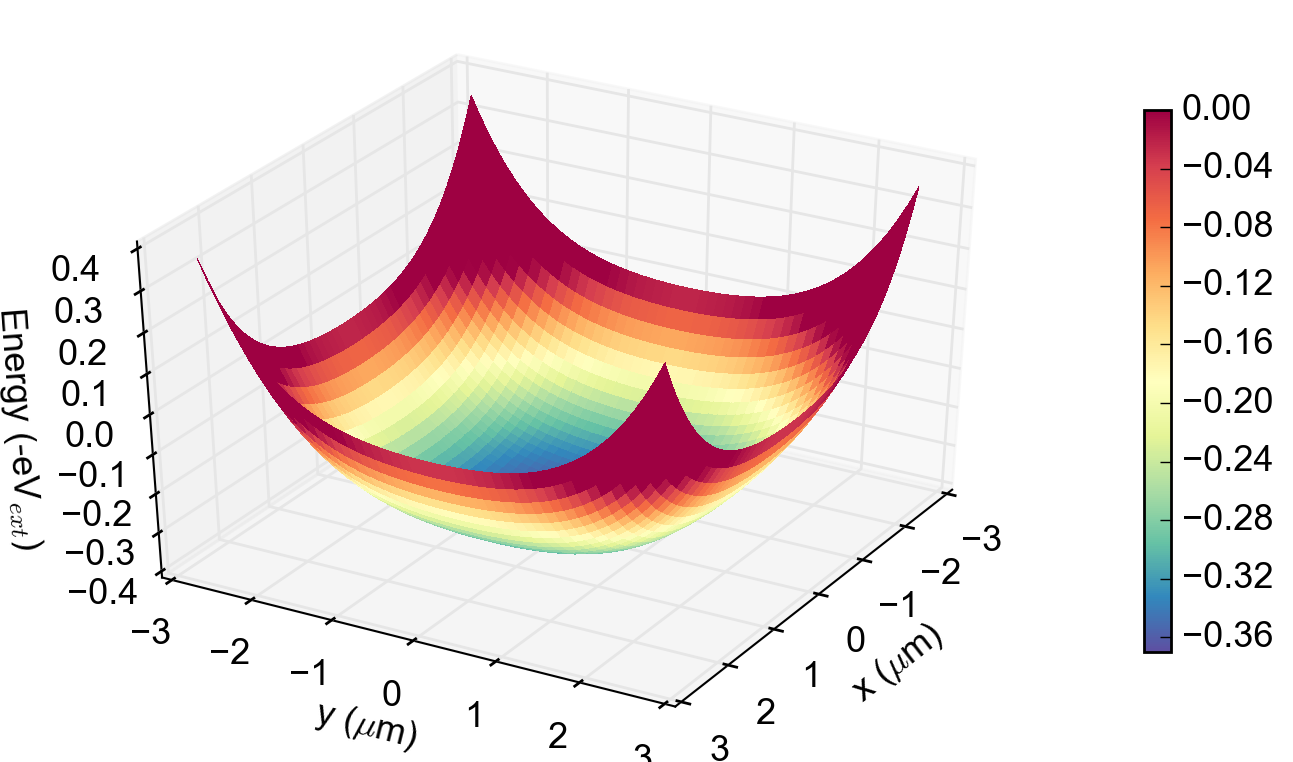

In [4]:
%matplotlib inline

gc = trap_analysis.get_constants()
resV = 0.5
save = False
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/50 electrons"

def Vext(xi, yi):
    # Offset
    a = 0.74
    # Curvatures in x-direction
    b = -7.0E-3 * 5.0E12
    c = -1.8E-3 * 5.0E24
    # Curvature in y-direction
    beta = -7.0E-3 * 5.0E12
    gamma = -1.8E-3 * 5.0E24
    return - gc['e'] * resV * (a + b*xi**2 + c*xi**4 + beta*yi**2 + gamma*yi**4)

xeval = np.linspace(-2.7E-6, 2.7E-6)
yeval = np.linspace(-2.7E-6, 2.7E-6)
X, Y = np.meshgrid(xeval, yeval)

fig = plt.figure(figsize=(7.,4.))
common.configure_axes(13)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X*1E6, Y*1E6, Vext(X,Y)/gc['e'], rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                       linewidth=0, antialiased=False, vmax=0.0)
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
ax.set_zlabel("Energy (-eV$_{ext}$)")
ax.view_init(elev=35., azim=30)
fig.colorbar(surf, shrink=0.75, aspect=20)
plt.tight_layout()
#fig.subplots_adjust(bottom=0.1, right=0.1)

if save: 
    common.save_figure(fig, save_path=save_path)

Just to keep track of all the speeds we want to see how fast the function evaluation is for the external potential.

In [5]:
%timeit np.sum(Vext(np.linspace(0, 1, 21), np.linspace(0, 1, 21)))

10000 loops, best of 3: 32.9 µs per loop


In [66]:
np.sum(np.array([[1, 1, 1], [2,2,2], [3,2,1]]), axis=0)

array([6, 5, 4])

In [90]:
def Velectrons(ri, eps=1E-15):
    """
    Returns the repulsion potential between two electrons separated by a distance sqrt(|xi-xj|**2 + |yi-yj|**2)
    Note the factor 1/2. in front of the potential energy to avoid overcounting.
    """
    Xi, Yi = np.meshgrid(ri[::2], ri[1::2])
    Xj, Yj = Xi.T, Yi.T
    
    Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
    np.fill_diagonal(Rij, eps)
    
    return + 1/2. * gc['e']**2/(4*np.pi*gc['eps0']) * 1/Rij

def Vtotal(r):
    """
    Returns the total energy of N electrons
    r is a 0D array with coordinates of the electrons, in the form 
    r = np.array([x0, y0, x1, y1, x2, y2, ... , xN, yN])
    The x-coordinates are thus given by the even elements of r: r[::2], 
    whereas the y-coordinates are the odd ones: r[1::2]
    """
    Vtot = np.sum(Vext(r[::2], r[1::2]))
    interaction_matrix = Velectrons(r)
    np.fill_diagonal(interaction_matrix, 0)
    Vtot += np.sum(interaction_matrix)
    return Vtot/gc['e']

def r2xy(r):
    x = r[::2]
    y = r[1::2]
    return x, y

def xy2r(x, y):
    if len(x) == len(y):
        r = np.zeros(2*len(x))
        r[::2] = x
        r[1::2] = y
        return r
    else:
        raise ValueError("x and y must have the same length!")
        return None

In [91]:
Vtotal(electron_initial_positions)

-2.2722550309393781

In [312]:
def gradx_Vext(xi, yi):
    # Curvatures in x-direction
    b = -7.0E-3 * 5.0E12
    c = -1.8E-3 * 5.0E24
    return - gc['e'] * resV * (2*b*xi + 4*c*xi**3)

def grady_Vext(xi, yi):
    # Curvature in y-direction
    beta = -7.0E-3 * 5.0E12
    gamma = -1.8E-3 * 5.0E24
    return - gc['e'] * resV * (2*beta*yi + 4*gamma*yi**3)

def gradient_Velectrons(ri, eps=1E-15):
    xi, yi = ri[::2], ri[1::2]
    
    Xi, Yi = np.meshgrid(xi, yi)
    Xj, Yj = Xi.T, Yi.T
    
    Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
    np.fill_diagonal(Rij, eps)
    
    gradx_matrix = np.zeros(np.shape(Rij))
    grady_matrix = np.zeros(np.shape(Rij))
    gradient = np.zeros(len(ri))
    
    gradx_matrix = -1 * gc['e']**2/(4*np.pi*gc['eps0']) * (Xi-Xj)/Rij**3
    np.fill_diagonal(gradx_matrix, 0)
    
    grady_matrix = +1 * gc['e']**2/(4*np.pi*gc['eps0']) * (Yi-Yj)/Rij**3
    np.fill_diagonal(grady_matrix, 0)
    
    gradient[::2] = np.sum(gradx_matrix, axis=0)
    gradient[1::2] = np.sum(grady_matrix, axis=0)
    
    return gradient

def total_gradient(r):
    dUdr = np.zeros(len(r))
    dUdr[::2] = gradx_Vext(r[::2], r[1::2])
    dUdr[1::2] = grady_Vext(r[::2], r[1::2])
    dUdr += gradient_Velectrons(r)
    return dUdr/gc['e']

Here are the parameters of the simulation. I arrange the electrons in a circle of radius `initial_radius`. The number of electrons can be tweaked by changing `N_electrons`

In [320]:
N_electrons = 50
initial_radius = 1.0E-6

xinit = initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/N_electrons) + 0.5E-6*np.random.randn(N_electrons)
yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/N_electrons) + 0.5E-6*np.random.randn(N_electrons)
electron_initial_positions = xy2r(xinit, yinit)

We can now evaluate the total potential at the initial positions of the electrons. This gives us an idea of the number we see when we start the minimization procedure. 

In [94]:
Vtotal(electron_initial_positions)

-2.2901294561305154

This number will always go down when we start the minimization (per definition). Let's find out how fast the function call is for the total energy:

In [10]:
%timeit Vtotal(electron_initial_positions)

The slowest run took 5.08 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 219 µs per loop


In [325]:
class ConvergenceMonitor:
    def __init__(self, N=2500, verbose=True, eps=1E-12):
        self.call_every = N
        self.call_counter = 0
        self.verbose = verbose
        self.curr_func_gradient = list()
        self.curr_func_val = list()
        self.func_calls = list()
        self.epsilon = eps
        self.save_path = r"/Users/gkoolstra/Desktop/Electron optimization/100 electrons"
    
    def monitor_convergence(self, xk):
        if not(self.call_counter%self.call_every):
            self.func_calls.append(self.call_counter)
            self.curr_func_val.append(Vtotal(xk))
            self.curr_func_gradient.append(np.sum(total_gradient(xk)))
            
            if self.call_counter == 0: 
                self.gradient_array = total_gradient(xk)
                self.approx_fprime = approx_fprime(xk, Vtotal, self.epsilon)
            else:
                self.gradient_array = np.vstack((self.gradient_array, total_gradient(xk)))
                self.approx_fprime = np.vstack((self.approx_fprime, approx_fprime(xk, Vtotal, self.epsilon)))

            if self.verbose:
                print("%d - function value / gradient: %.8f / %.8e"\
                      %(self.call_counter, self.curr_func_val[-1], self.curr_func_gradient[-1]))
        
        self.call_counter += 1 
    
    def save_pictures(self, xk):
        fig = plt.figure(figsize=(5,4))
        common.configure_axes(12)
        plt.pcolormesh(X*1E6, Y*1E6, Vext(X,Y)/gc['e'], cmap=plt.cm.Spectral_r, vmax=0.0)
        plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
        plt.plot(xk[::2]*1E6, xk[1::2]*1E6, 'o', color='deepskyblue')
        plt.xlim(-2.7, 2.7)
        plt.ylim(plt.xlim())
        plt.xlabel("$x$ ($\mu$m)")
        plt.ylabel("$y$ ($\mu$m)")
        plt.colorbar()
        
        fig.savefig(os.path.join(self.save_path, '%.5d.png'%(self.call_counter)), bbox_inches='tight')
        
        self.monitor_convergence(xk)
        
    def create_movie():
        curr_dir = os.getcwd()
        os.chdir(self.save_path)
        os.system(r"ffmpeg -r 5 -b 1800 -i %05d.png movie.mp4")
        os.chdir(curr_dir)

In [293]:
np.sum(total_gradient(electron_initial_positions))

-202523.36063305495

Here is the actual minimization. First we set the matplotlib to Agg to suppress any plots that may come up. For callback we can choose `monitor_convergence` for simply printing the total energy every `N` iterations. We can also choose `save_pictures` to create a movie afterwards. The latter also prints the function value every `N` iterations. 

In [243]:
print(ConvMon.approx_fprime[:3,:])
print(ConvMon.gradient_array[:3,:])

[[  -762.54201553 -18385.73437607   5405.94465004  15921.25551375]
 [  1489.29641353  -2685.03575929   1305.18578634   1151.10338894]
 [   267.22231272  -1653.42954683    -77.47543951   1708.95713958]]
[[ 5082.60572286 -7679.76527304  -396.79659434  5015.95555811]
 [  873.38920265  1794.21274203  1908.54658878 -3410.54121831]
 [ -992.36264132  2727.53270332  1168.55928547 -2752.69988571]]


In [311]:
print(grady_Vext(res['x'][::2], res['x'][1::2])/gc['e'])
print(2*gradient_Velectrons(res['x'])[1::2]/gc['e'])

[  -161.26435152  15904.43631083  10314.75010312     35.23768989
 -10087.34846808 -16006.10450431]
[  -161.21776314  15904.52020245  10314.81034814     35.29525272
 -10087.35231066 -16006.05572952]


/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


0 - function value / gradient: -15.42003599 / 3.24319342e+05
5 - function value / gradient: -15.66210636 / 9.68792810e+04
10 - function value / gradient: -15.67782796 / 2.33167154e+03
15 - function value / gradient: -15.67895613 / -1.72476959e+03
20 - function value / gradient: -15.67952455 / 8.40107546e+02
25 - function value / gradient: -15.67998154 / 8.67835866e+01
30 - function value / gradient: -15.68003814 / -1.80137878e+01
35 - function value / gradient: -15.68005395 / -2.94743033e+02
40 - function value / gradient: -15.68007230 / -3.45685310e+02
45 - function value / gradient: -15.68009408 / -3.04731964e+01
50 - function value / gradient: -15.68012083 / 9.80960053e+01
55 - function value / gradient: -15.68013289 / -2.74407263e+01
60 - function value / gradient: -15.68013971 / 3.54213985e+01
65 - function value / gradient: -15.68014155 / -5.86267846e+00
70 - function value / gradient: -15.68014207 / 2.15482598e+01
75 - function value / gradient: -15.68014221 / -2.34324217e+00
80

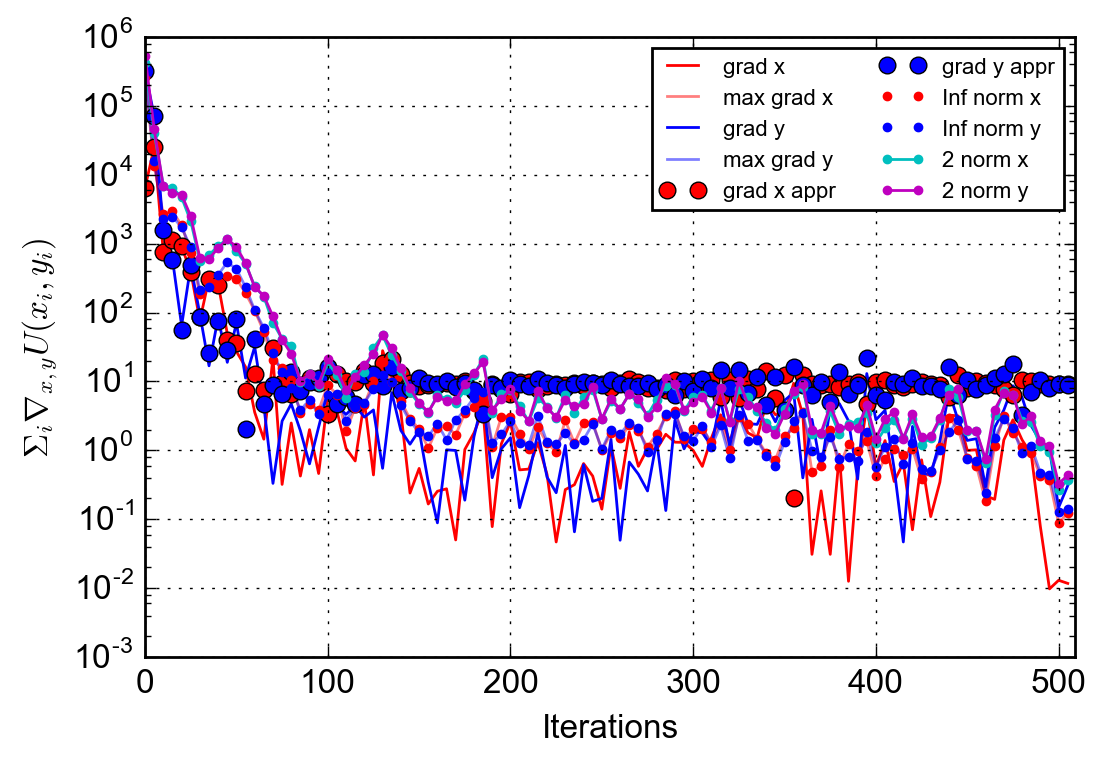

In [332]:
import matplotlib
from numpy import Inf
matplotlib.use('Agg')

epsilon = 2e-12
ConvMon = ConvergenceMonitor(verbose=True, N=5, eps=epsilon)

res = minimize(Vtotal, electron_initial_positions, method='CG', 
               jac=total_gradient, #lambda x: approx_fprime(x, Vtotal, epsilon),
               options={'disp': True, 'eps' : epsilon, 'gtol' : 1E-1, 'norm' : Inf}, 
               callback=ConvMon.monitor_convergence)

x, y = r2xy(res['x'])

if save: 
    common.save_figure(figgy, save_path=save_path)
    
if len(np.shape(ConvMon.gradient_array))>1:
    figgy = plt.figure(figsize=(6,4))
    common.configure_axes(12)
    plt.plot(ConvMon.func_calls, np.abs(np.sum(ConvMon.gradient_array[:,::2], axis=1)), '-r', label='grad x')
    plt.plot(ConvMon.func_calls, np.max(np.abs(ConvMon.gradient_array[:,::2]), axis=1), '-r', 
             alpha=0.5, label='max grad x')
    plt.plot(ConvMon.func_calls, np.abs(np.sum(ConvMon.gradient_array[:,1::2], axis=1)), '-b', label='grad y')
    plt.plot(ConvMon.func_calls, np.max(np.abs(ConvMon.gradient_array[:,1::2]), axis=1), '-b', 
             alpha=0.5, label='max grad y')
    plt.plot(ConvMon.func_calls, np.abs(np.sum(ConvMon.approx_fprime[:,::2], axis=1)), 'or', label='grad x appr')
    plt.plot(ConvMon.func_calls, np.abs(np.sum(ConvMon.approx_fprime[:,1::2], axis=1)), 'ob', label='grad y appr')

    plt.plot(ConvMon.func_calls, np.amax(np.abs(ConvMon.gradient_array[:,::2]), axis=1), 
             '.r', label='Inf norm x')
    plt.plot(ConvMon.func_calls, np.amax(np.abs(ConvMon.gradient_array[:,1::2]), axis=1), 
             '.b', label='Inf norm y')
    
    plt.plot(ConvMon.func_calls, np.sum(np.abs(ConvMon.gradient_array[:,::2])**2.0, axis=1)**(1/2.), 
             '.-c', label='2 norm x')
    plt.plot(ConvMon.func_calls, np.sum(np.abs(ConvMon.gradient_array[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-m', label='2 norm y')

    plt.xlabel("Iterations")
    plt.ylabel(r"$\Sigma_i \nabla_{x,y} U(x_i, y_i)$")
    plt.yscale('log')
    plt.xlim(0, res['nit'])
    plt.grid()
    plt.legend(loc=0, ncol=2, prop = {'size' : 8})

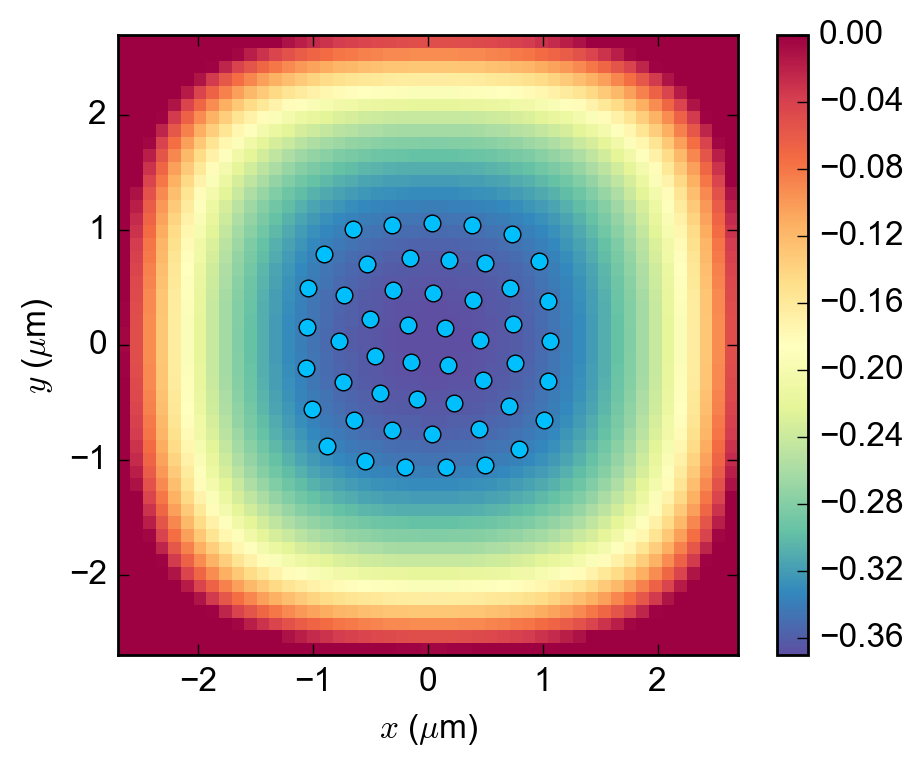

In [330]:
%matplotlib inline
figgy = plt.figure(figsize=(5,4))
common.configure_axes(12)
plt.pcolormesh(X*1E6, Y*1E6, Vext(X,Y)/gc['e'], cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
#plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
plt.xlim(-2.7, 2.7)
plt.ylim(plt.xlim())
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)

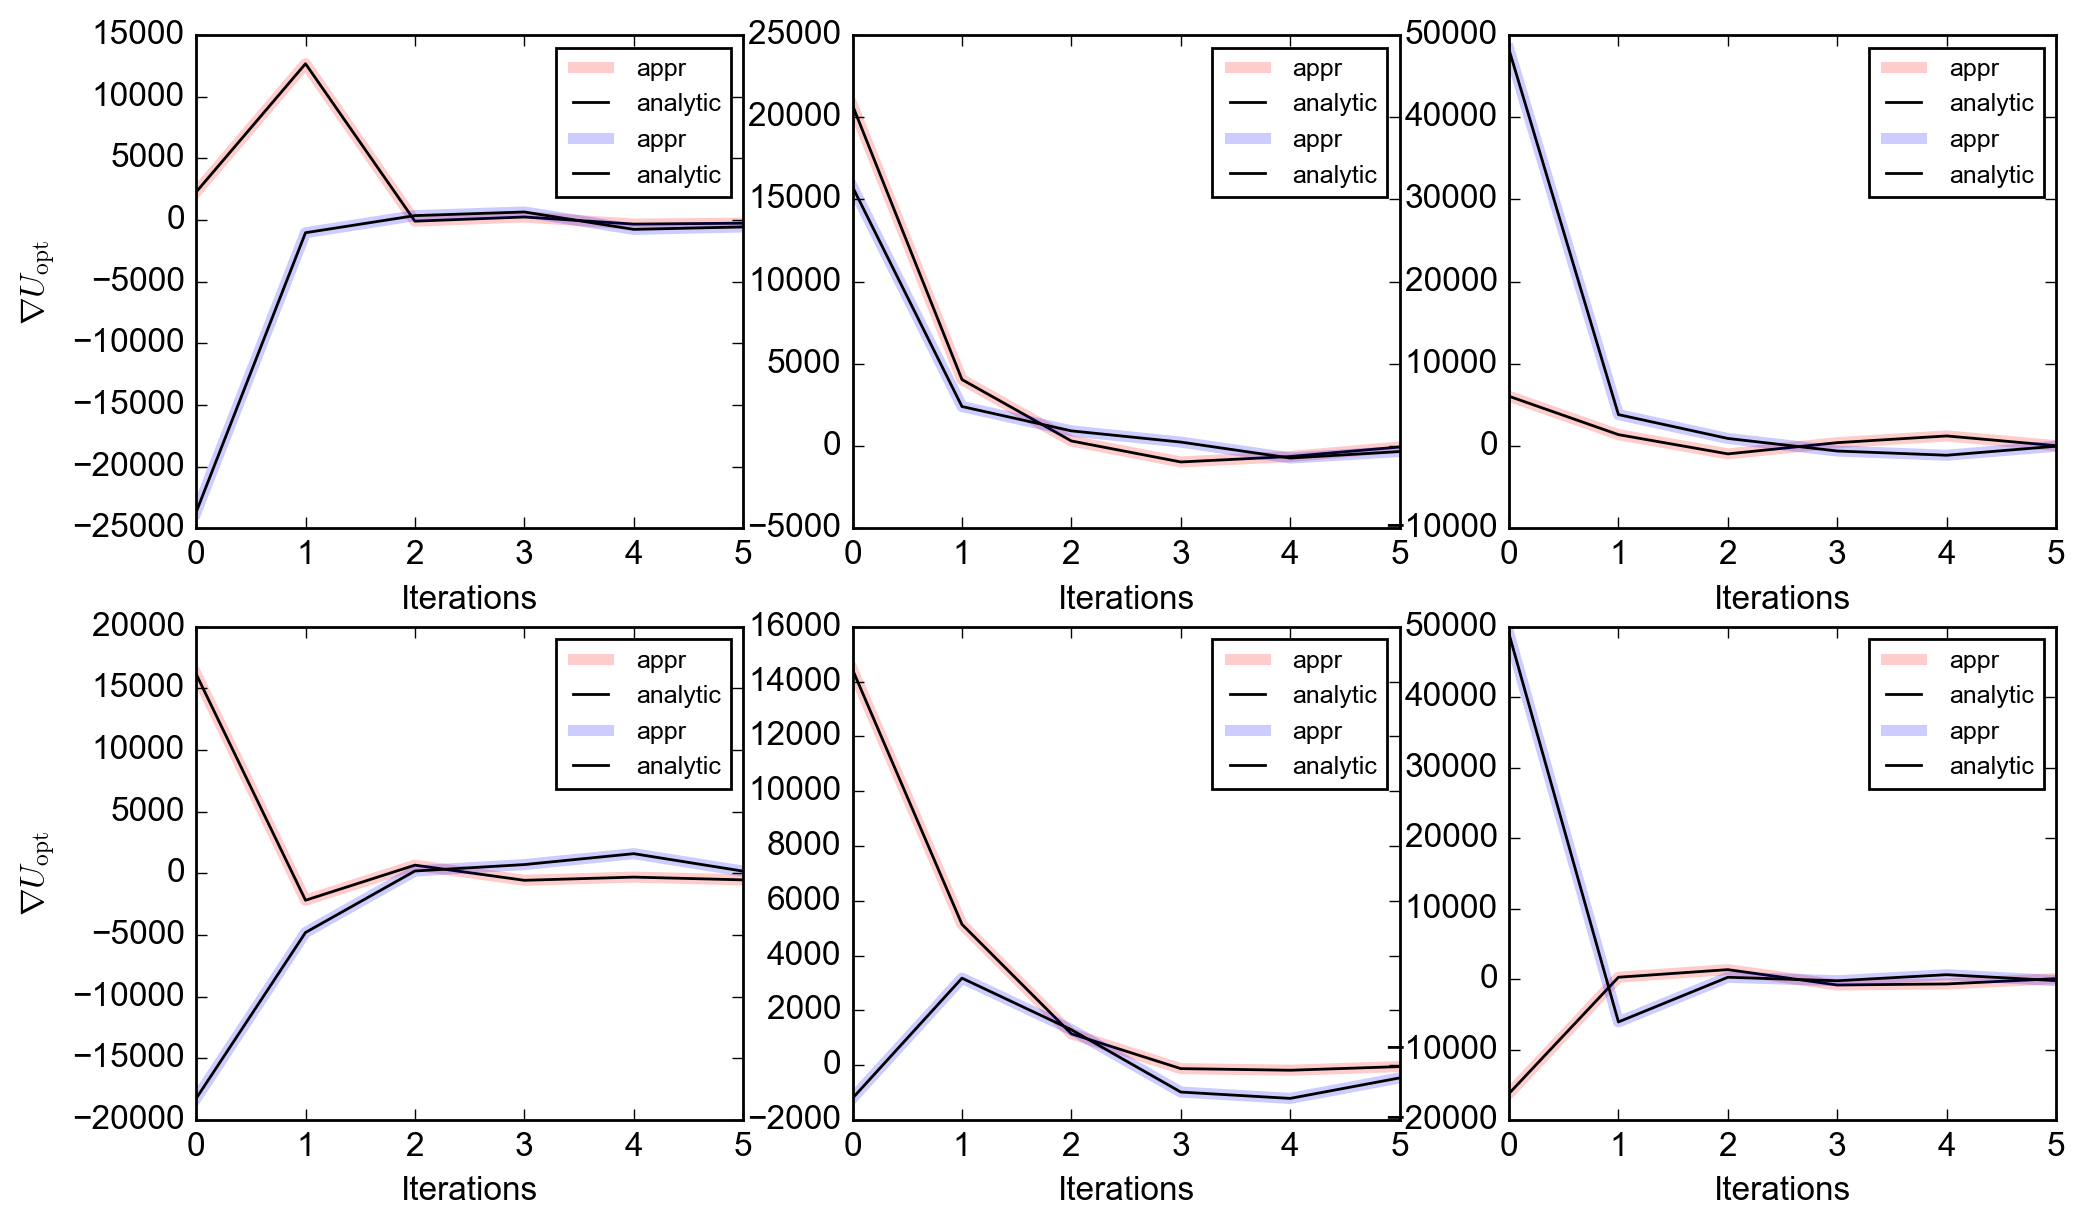

In [334]:
plt.figure(figsize=(12.,7.))

for n in range(6):
    plt.subplot(2,3,n+1)
    plt.plot(ConvMon.approx_fprime[:,2*n], 'r', alpha=0.2, lw=4.0, label='appr')
    plt.plot(ConvMon.gradient_array[:,2*n], 'k', label='analytic')
    plt.plot(ConvMon.approx_fprime[:,2*n+1], 'b', alpha=0.2, lw=4.0, label='appr')
    plt.plot(ConvMon.gradient_array[:,2*n+1], 'k', label='analytic')
    #plt.plot(grady_Vext(res['x'][::2], res['x'][1::2])/gc['e'])
    if not n%3:
        plt.ylabel(r"$\nabla U_\mathrm{opt}$")
    
    plt.xlabel('Iterations')
    plt.xlim(0, 5)
    
    plt.legend(loc=0, prop={'size':9})